In [1]:
import numpy as np
import os
import cv2
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, Conv2DTranspose, Input, \
    concatenate, Activation
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

mixed_precision.set_global_policy('mixed_float16')

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Define class labels
CLASS_NAMES = {
    0: "epidural",
    1: "intraparenchymal",
    2: "intraventricular",
    3: "multi",
    4: "normal",
    5: "subarachnoid",
    6: "subdural"
}

In [2]:
def load_and_stack_as_rgb(brain_bone_path, brain_path, subdural_path):
    """
    Reads three grayscale images and combines them into an RGB image.

    - brain_bone_window → Red channel
    - brain_window → Green channel
    - subdural_window → Blue channel

    Returns a (H, W, 3) RGB image.
    """
    # Load grayscale images
    brain_bone = cv2.imread(brain_bone_path, cv2.IMREAD_GRAYSCALE)
    brain = cv2.imread(brain_path, cv2.IMREAD_GRAYSCALE)
    subdural = cv2.imread(subdural_path, cv2.IMREAD_GRAYSCALE)

    # Ensure all images are the same shape
    if not (brain_bone.shape == brain.shape == subdural.shape):
        raise ValueError("Input images do not have same size")

    if not (brain_bone.shape == (512, 512)):
        print("\nbrain_bone.shape = ", brain_bone.shape, "\tbrain.shape = ", brain.shape, "\tsubdural.shape = ",
              subdural.shape)
        print("Path = ", brain_bone_path)

    # Normalize pixel values to [0,1] (optional, but recommended)
    brain_bone = brain_bone / 255.0
    brain = brain / 255.0
    subdural = subdural / 255.0

    # Stack images into an RGB format
    rgb_image = np.stack([brain_bone, brain, subdural], axis=-1)

    # Convert back to 0-255 and uint8 for visualization/saving
    # rgb_image = (rgb_image * 255).astype(np.uint8)

    return rgb_image


def find_matching_image_paths(bone_folder, brain_folder, subdural_folder):
    """
    Walks through the subfolders and finds images with the same filename across all three directories.

    Returns a list of tuples containing matching image paths from each folder.
    """
    # Get the list of all image filenames in each directory
    bone_images = set(os.listdir(bone_folder))
    brain_images = set(os.listdir(brain_folder))
    subdural_images = set(os.listdir(subdural_folder))

    # Find common filenames across all three folders
    common_files = bone_images.intersection(brain_images).intersection(subdural_images)

    # Create a list of tuples with paths to the matching images
    matching_image_paths = []
    for filename in common_files:
        bone_path = os.path.join(bone_folder, filename)
        brain_path = os.path.join(brain_folder, filename)
        subdural_path = os.path.join(subdural_folder, filename)
        matching_image_paths.append((bone_path, brain_path, subdural_path))

    return matching_image_paths

def load_image(file_path):
    """
    Load an image file, decode it, and convert to float32.
    """
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1)  # or decode_jpeg depending on your files
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def load_and_preprocess_image(file_path, target_size=(256, 256)):
    """
    Load an image file, decode it, resize it, and convert to float32.
    """
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1)  # or decode_jpeg

    # Resize to smaller dimensions to save memory
    img = tf.image.resize(img, target_size)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(bone_path, brain_path, subdural_path, label, target_size=(256, 256)):
    # Load and resize the images
    bone_img = load_and_preprocess_image(bone_path, target_size)
    brain_img = load_and_preprocess_image(brain_path, target_size)
    subdural_img = load_and_preprocess_image(subdural_path, target_size)

    # Apply contrast enhancement
    bone_img = tf.image.adjust_contrast(bone_img, 1.5)
    brain_img = tf.image.adjust_contrast(brain_img, 1.5)
    subdural_img = tf.image.adjust_contrast(subdural_img, 1.5)

    # Ensure normalization is consistent
    bone_img = tf.clip_by_value(bone_img, 0.0, 1.0)
    brain_img = tf.clip_by_value(brain_img, 0.0, 1.0)
    subdural_img = tf.clip_by_value(subdural_img, 0.0, 1.0)

    # Stack the images
    image = tf.concat([bone_img, brain_img, subdural_img], axis=-1)

    return image, label

def prepare_path_and_label_lists():
    """
    Prepare lists of file paths and corresponding labels.
    """
    # List of (folder_prefixes, class_label)
    class_info = [
        ("epidural", 0),
        ("intraparenchymal", 1),
        ("intraventricular", 2),
        ("multi", 3),
        ("normal", 4),
        ("subarachnoid", 5),
        ("subdural", 6)
    ]

    all_bone_paths = []
    all_brain_paths = []
    all_subdural_paths = []
    all_labels = []

    # Use a smaller number for each class to reduce memory usage
    min_num_type = 1000  # Reduced from 1000

    for prefix, label in class_info:
        bone_folder = f'renders/{prefix}/brain_bone_window'
        brain_folder = f'renders/{prefix}/brain_window'
        subdural_folder = f'renders/{prefix}/subdural_window'

        matching_paths = find_matching_image_paths(bone_folder, brain_folder, subdural_folder)
        selected_paths = matching_paths[:min_num_type]

        for bone_path, brain_path, subdural_path in selected_paths:
            all_bone_paths.append(bone_path)
            all_brain_paths.append(brain_path)
            all_subdural_paths.append(subdural_path)
            all_labels.append(label)

    return all_bone_paths, all_brain_paths, all_subdural_paths, all_labels

def configure_for_performance(ds, batch_size=8, buffer_size=1000, shuffle=True):
    """
    Configure dataset for performance with reduced batch size.
    """
    # Shuffle if needed
    if shuffle:
        ds = ds.shuffle(buffer_size=buffer_size)

    # Use smaller batch size
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

def create_hemorrhage_datasets(batch_size=8, validation_split=0.2, test_split=0.1,
                              target_size=(256, 256), seed=42):
    """
    Create train, validation, and test datasets with memory optimizations.
    """
    # Get file paths and labels
    bone_paths, brain_paths, subdural_paths, labels = prepare_path_and_label_lists()

    # Convert to tensors
    bone_paths = tf.convert_to_tensor(bone_paths)
    brain_paths = tf.convert_to_tensor(brain_paths)
    subdural_paths = tf.convert_to_tensor(subdural_paths)
    labels = tf.convert_to_tensor(labels)

    # Calculate dataset sizes
    dataset_size = len(labels)
    test_size = int(test_split * dataset_size)
    val_size = int(validation_split * dataset_size)
    train_size = dataset_size - val_size - test_size

    # Create full dataset
    full_dataset = tf.data.Dataset.from_tensor_slices((bone_paths, brain_paths, subdural_paths, labels))

    # Shuffle
    full_dataset = full_dataset.shuffle(buffer_size=dataset_size, seed=seed)

    # Split into train, validation, and test
    train_ds = full_dataset.take(train_size)
    remaining_ds = full_dataset.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    # Map to process the data with resizing
    train_ds = train_ds.map(
        lambda b, br, s, l: process_path(b, br, s, l, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_ds = val_ds.map(
        lambda b, br, s, l: process_path(b, br, s, l, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    test_ds = test_ds.map(
        lambda b, br, s, l: process_path(b, br, s, l, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Configure datasets for performance with smaller batch size
    train_ds = configure_for_performance(train_ds, batch_size=batch_size, shuffle=True)
    val_ds = configure_for_performance(val_ds, batch_size=batch_size, shuffle=False)
    test_ds = configure_for_performance(test_ds, batch_size=batch_size, shuffle=False)

    return train_ds, val_ds, test_ds

# Function to create a model (modify according to your needs)
def create_model(input_shape=(512, 512, 3), num_classes=7):
    """
    Create a CNN model for hemorrhage classification.
    """
    # You can use your own model architecture here
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Freeze the base model
    base_model.trainable = False

    # Add classification head
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create a lighter model
def create_lightweight_model(input_shape=(256, 256, 3), num_classes=7):
    """
    Create a more memory-efficient CNN model for hemorrhage classification.
    """
    inputs = tf.keras.Input(shape=input_shape)

    # Use MobileNetV2 instead of ResNet50 (much lighter)
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        input_shape=input_shape
    )

    # Freeze the base model
    base_model.trainable = False

    # Add classification head
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # Smaller dense layer
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile with mixed precision
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    if tf.config.list_physical_devices('GPU'):
        # Use mixed precision if GPU is available
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Alternative: Custom lightweight CNN
def create_custom_cnn(input_shape=(256, 256, 3), num_classes=7):
    """
    Create a custom lightweight CNN that uses less memory than pre-trained models.
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),

        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),

        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),

        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),

        # Flatten and dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_improved_cnn(input_shape=(256, 256, 3), num_classes=7):
    # Create a more specialized model for medical imaging
    inputs = tf.keras.Input(shape=input_shape)

    # First block - focus on edge detection
    x = tf.keras.layers.Conv2D(32, (5, 5), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Second block - more features
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Third block - deeper features
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Feature extraction
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Classification head
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def build_unet_classifier_with_pretrained_encoder(input_shape=(256, 256, 3), num_classes=7, encoder_type='resnet50', pretrained=True):
    """
    Build U-Net with a pre-trained encoder backbone for classification tasks

    Args:
        input_shape: Input shape of the images
        num_classes: Number of classes for classification
        encoder_type: 'resnet50' or 'xception'
        pretrained: Whether to use pre-trained weights (True) or random initialization (False)

    Returns:
        U-Net model adapted for classification tasks
    """
    inputs = Input(shape=input_shape)

    # Select pre-trained encoder
    if encoder_type == 'resnet50':
        weights = 'imagenet' if pretrained else None
        base_model = ResNet50(include_top=False, weights=weights, input_tensor=inputs)

        # Extract skip connection layers
        s1 = base_model.get_layer('conv1_relu').output       # 256x256
        s2 = base_model.get_layer('conv2_block3_out').output  # 128x128
        s3 = base_model.get_layer('conv3_block4_out').output  # 64x64
        s4 = base_model.get_layer('conv4_block6_out').output  # 32x32

        # Bridge
        bridge = base_model.get_layer('conv5_block3_out').output  # 16x16

    elif encoder_type == 'xception':
        weights = 'imagenet' if pretrained else None
        base_model = Xception(include_top=False, weights=weights, input_tensor=inputs)

        # Extract skip connection layers
        s1 = base_model.get_layer('block2_sepconv2_bn').output  # 128x128
        s2 = base_model.get_layer('block3_sepconv2_bn').output  # 64x64
        s3 = base_model.get_layer('block4_sepconv2_bn').output  # 32x32
        s4 = base_model.get_layer('block13_sepconv2_bn').output  # 16x16

        # Bridge
        bridge = base_model.get_layer('block14_sepconv2_bn').output  # 16x16
    else:
        raise ValueError(f"Unsupported encoder type: {encoder_type}. Choose 'resnet50' or 'xception'")

    # Decoder path - but with fewer upsampling blocks for classification
    # First upsampling block
    u1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(bridge)
    u1 = concatenate([u1, s4])
    u1 = Conv2D(512, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Dropout(0.3)(u1)

    # Second upsampling block
    u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = concatenate([u2, s3])
    u2 = Conv2D(256, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Dropout(0.3)(u2)

    # Global average pooling for classification
    gap = GlobalAveragePooling2D()(u2)

    # Classification head
    x = Dense(256, activation='relu')(gap)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def set_encoder_trainable(model, trainable=False):
    """
    Set trainable property of the encoder layers

    Args:
        model: The U-Net model with pre-trained encoder
        trainable: Whether to make encoder layers trainable (True) or frozen (False)
    """
    # Find the pre-trained backbone layers
    for layer in model.layers:
        if isinstance(layer, tf.keras.models.Model):  # This is the base model
            for base_layer in layer.layers:
                base_layer.trainable = trainable

    return model

In [3]:
if __name__ == "__main__":
    # Set memory growth for GPU if available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    # Create datasets with smaller batch size and image dimensions
    train_ds, val_ds, test_ds = create_hemorrhage_datasets(
        batch_size=4,  # Reduced batch size
        target_size=(256, 256)  # Smaller image size
    )

    # Create a lightweight model
    model = create_improved_cnn(input_shape=(256, 256, 3))
    # Alternatively: model = create_lightweight_model(input_shape=(224, 224, 3))

    # Set up callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath='cat_model.h5',
            monitor='val_accuracy',
            save_best_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3
        )
    ]

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=callbacks
    )

KeyboardInterrupt: 

In [27]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.2065 - loss: 1.8636
Test accuracy: 0.1757


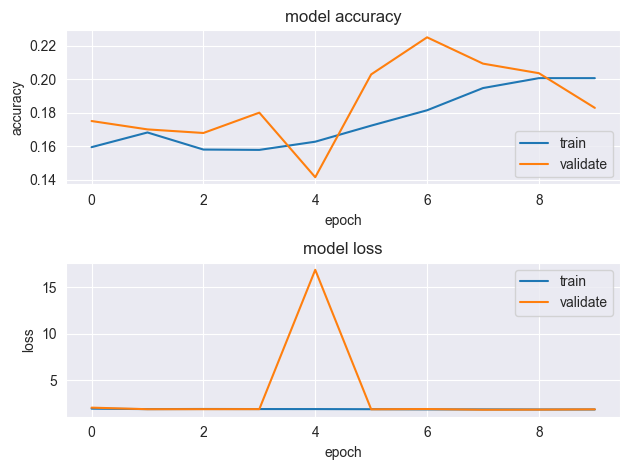

In [28]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

In [32]:
model.load_weights('cat_model.h5')
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.2138 - loss: 1.9137
Test accuracy: 0.2271


In [34]:
if __name__ == "__main__":
    # Set memory growth for GPU if available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

# Create datasets with smaller batch size and image dimensions
    train_ds, val_ds, test_ds = create_hemorrhage_datasets(
        batch_size=4,  # Reduced batch size
        target_size=(256, 256)  # Smaller image size
    )

    # Create a lightweight model
    model = create_improved_cnn(input_shape=(256, 256, 3))
    # Alternatively: model = create_lightweight_model(input_shape=(224, 224, 3))

    # Set up callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath='cat_model2.h5',
            monitor='val_accuracy',
            save_best_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=10
        )
    ]

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=callbacks
    )

Epoch 1/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.1585 - loss: 2.0132

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 427s 344ms/step - accuracy: 0.1585 - loss: 2.0131 - val_accuracy: 0.1621 - val_loss: 1.9520 - learning_rate: 0.0010
Epoch 2/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 388s 315ms/step - accuracy: 0.1664 - loss: 1.9198 - val_accuracy: 0.1393 - val_loss: 2.6040 - learning_rate: 0.0010
Epoch 3/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 399s 324ms/step - accuracy: 0.1595 - loss: 1.9203 - val_accuracy: 0.1486 - val_loss: 1.9560 - learning_rate: 0.0010
Epoch 4/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 414s 337ms/step - accuracy: 0.1546 - loss: 1.9412 - val_accuracy: 0.1571 - val_loss: 1.9461 - learning_rate: 0.0010
Epoch 5/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 412s 335ms/step - accuracy: 0.1317 - loss: 1.9471 - val_accuracy: 0.1393 - val_loss: 1.9457 - learning_rate: 0.0010
Epoch 6/30
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 407s 331ms/step - accuracy: 0.1317 - loss: 1.9471 - val_accuracy: 0.1329 - val_loss: 1.9458 - learning_rate: 0.0010


In [35]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.1626 - loss: 1.9462
Test accuracy: 0.1429


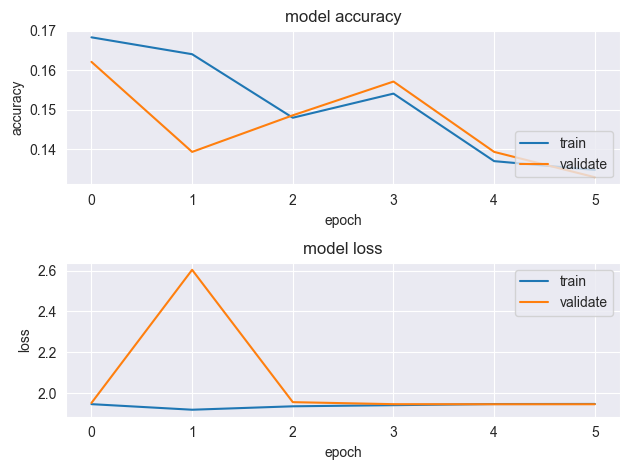

In [36]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

In [37]:
model.load_weights('cat_model2.h5')
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.1466 - loss: 1.9504
Test accuracy: 0.1571


In [38]:
model.load_weights('cat_model.h5')
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.1797 - loss: 1.9627
Test accuracy: 0.1971


In [40]:
# Import necessary dependencies (already included in your code)
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

# Create datasets (using your existing function)
train_ds, val_ds, test_ds = create_hemorrhage_datasets(
    batch_size=8,
    validation_split=0.2,
    test_split=0.1,
    target_size=(256, 256)
)

# Create the U-Net classifier model
unet_classifier = build_unet_classifier_with_pretrained_encoder(
    input_shape=(256, 256, 3),
    num_classes=7,
    encoder_type='resnet50',
    pretrained=True
)

# Initially, freeze the encoder weights
unet_classifier = set_encoder_trainable(unet_classifier, trainable=False)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'unet_classifier_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model with frozen encoder
history = unet_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tune the model by unfreezing the encoder
unet_classifier = set_encoder_trainable(unet_classifier, trainable=True)

# Lower learning rate for fine-tuning
unet_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with unfrozen encoder
fine_tune_history = unet_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1707 - loss: 1.9602

613/613 ━━━━━━━━━━━━━━━━━━━━ 2073s 3s/step - accuracy: 0.1707 - loss: 1.9601 - val_accuracy: 0.2307 - val_loss: 1.8670
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 1999s 3s/step - accuracy: 0.2070 - loss: 1.8715 - val_accuracy: 0.1729 - val_loss: 1.9272
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 1987s 3s/step - accuracy: 0.2134 - loss: 1.8541 - val_accuracy: 0.1807 - val_loss: 5.9494
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2426 - loss: 1.8378

613/613 ━━━━━━━━━━━━━━━━━━━━ 1982s 3s/step - accuracy: 0.2426 - loss: 1.8378 - val_accuracy: 0.2621 - val_loss: 1.8505
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2095s 3s/step - accuracy: 0.2254 - loss: 1.8530 - val_accuracy: 0.1971 - val_loss: 1.9545
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2121s 3s/step - accuracy: 0.2294 - loss: 1.8458 - val_accuracy: 0.2264 - val_loss: 1.8871
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 1972s 3s/step - accuracy: 0.2295 - loss: 1.8532 - val_accuracy: 0.1871 - val_loss: 1.9097
Epoch 8/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2013s 3s/step - accuracy: 0.2436 - loss: 1.8362 - val_accuracy: 0.1900 - val_loss: 2.3451
Epoch 9/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 1980s 3s/step - accuracy: 0.2462 - loss: 1.8228 - val_accuracy: 0.2179 - val_loss: 1.8445
Epoch 10/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 1960s 3s/step - accuracy: 0.2444 - loss: 1.8454 - val_accuracy: 0.2179 - val_loss: 1.8597
Epoch 11/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 1956s 3s/step - accuracy: 0.2433 - loss: 1.8327 - val_accur

613/613 ━━━━━━━━━━━━━━━━━━━━ 2067s 3s/step - accuracy: 0.2511 - loss: 1.8237 - val_accuracy: 0.2786 - val_loss: 1.7810
Epoch 2/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 2132s 3s/step - accuracy: 0.2710 - loss: 1.7902 - val_accuracy: 0.2736 - val_loss: 1.7628
Epoch 3/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2594 - loss: 1.8021

613/613 ━━━━━━━━━━━━━━━━━━━━ 2130s 3s/step - accuracy: 0.2594 - loss: 1.8021 - val_accuracy: 0.2800 - val_loss: 1.7789
Epoch 4/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 2082s 3s/step - accuracy: 0.2639 - loss: 1.8069 - val_accuracy: 0.2600 - val_loss: 1.8226
Epoch 5/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 1989s 3s/step - accuracy: 0.2718 - loss: 1.7807 - val_accuracy: 0.2743 - val_loss: 1.7965
Epoch 6/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2691 - loss: 1.7758

613/613 ━━━━━━━━━━━━━━━━━━━━ 2024s 3s/step - accuracy: 0.2691 - loss: 1.7758 - val_accuracy: 0.3057 - val_loss: 1.7511
Epoch 7/10
 21/613 ━━━━━━━━━━━━━━━━━━━━ 34:37 4s/step - accuracy: 0.2561 - loss: 1.7666

KeyboardInterrupt: 

In [42]:
# Evaluate the model on test data
unet_classifier.load_weights('unet_classifier_best.h5')
test_loss, test_accuracy = unet_classifier.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 826ms/step - accuracy: 0.2895 - loss: 1.7683
Test accuracy: 0.3029


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


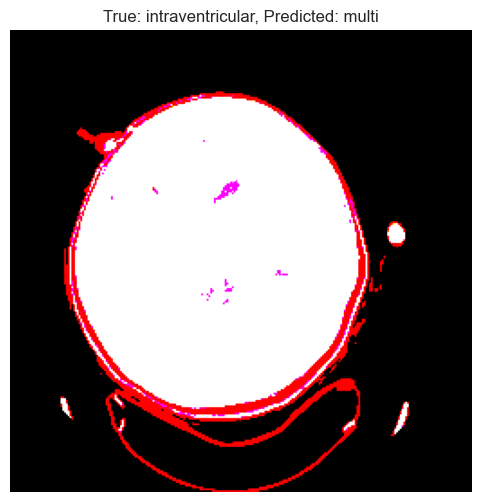

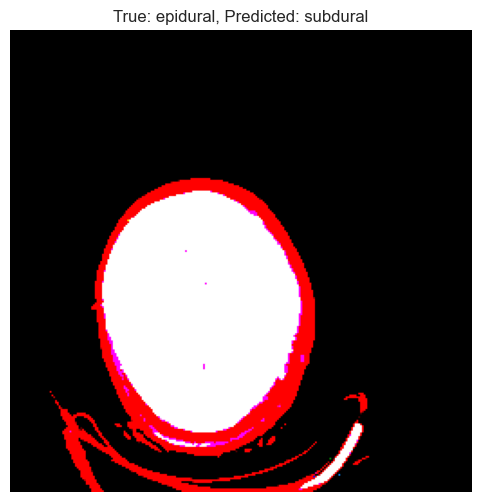

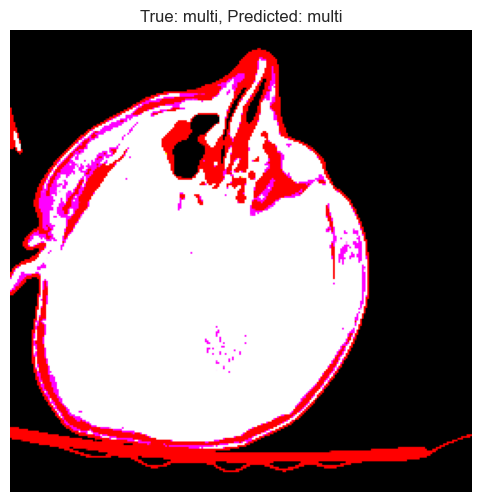

In [43]:
# Make predictions
for images, labels in test_ds.take(1):
    predictions = unet_classifier.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    # Display sample images with true and predicted labels
    for i in range(min(3, len(images))):
        plt.figure(figsize=(8, 6))
        plt.imshow(images[i])
        true_class = CLASS_NAMES[labels[i].numpy()]
        pred_class = CLASS_NAMES[predicted_classes[i]]
        plt.title(f"True: {true_class}, Predicted: {pred_class}")
        plt.axis('off')
        plt.show()

In [3]:
# START HERE FOR XCEPTION ALTERNATIVE
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

# Create datasets (using your existing function)
train_ds, val_ds, test_ds = create_hemorrhage_datasets(
    batch_size=8,
    validation_split=0.2,
    test_split=0.1,
    target_size=(256, 256)
)

# Create the U-Net classifier model
unet_classifier = build_unet_classifier_with_pretrained_encoder(
    input_shape=(256, 256, 3),
    num_classes=7,
    encoder_type='xception',
    pretrained=True
)

# Initially, freeze the encoder weights
unet_classifier = set_encoder_trainable(unet_classifier, trainable=False)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'xception_classifier_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model with frozen encoder
history = unet_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tune the model by unfreezing the encoder
unet_classifier = set_encoder_trainable(unet_classifier, trainable=True)

# Lower learning rate for fine-tuning
unet_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with unfrozen encoder
fine_tune_history = unet_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1809 - loss: 1.9479

613/613 ━━━━━━━━━━━━━━━━━━━━ 2548s 4s/step - accuracy: 0.1810 - loss: 1.9478 - val_accuracy: 0.1736 - val_loss: 1.9940
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2498s 4s/step - accuracy: 0.2276 - loss: 1.8535 - val_accuracy: 0.1593 - val_loss: 2.0519
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2523 - loss: 1.8208

613/613 ━━━━━━━━━━━━━━━━━━━━ 2470s 4s/step - accuracy: 0.2523 - loss: 1.8208 - val_accuracy: 0.2614 - val_loss: 1.7845
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2453s 4s/step - accuracy: 0.2803 - loss: 1.7936 - val_accuracy: 0.2579 - val_loss: 1.7806
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2647 - loss: 1.7936

613/613 ━━━━━━━━━━━━━━━━━━━━ 2396s 4s/step - accuracy: 0.2647 - loss: 1.7936 - val_accuracy: 0.2871 - val_loss: 1.7840
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2424s 4s/step - accuracy: 0.2733 - loss: 1.7894 - val_accuracy: 0.2807 - val_loss: 1.7507
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2772 - loss: 1.7956

613/613 ━━━━━━━━━━━━━━━━━━━━ 2395s 4s/step - accuracy: 0.2772 - loss: 1.7956 - val_accuracy: 0.3000 - val_loss: 1.7435
Epoch 8/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2421s 4s/step - accuracy: 0.3028 - loss: 1.7398 - val_accuracy: 0.2679 - val_loss: 1.7769
Epoch 9/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2410s 4s/step - accuracy: 0.2983 - loss: 1.7314 - val_accuracy: 0.1914 - val_loss: 2.0618
Epoch 10/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2391s 4s/step - accuracy: 0.2971 - loss: 1.7304 - val_accuracy: 0.2907 - val_loss: 1.7621
Epoch 11/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3115 - loss: 1.7129

613/613 ━━━━━━━━━━━━━━━━━━━━ 2404s 4s/step - accuracy: 0.3115 - loss: 1.7129 - val_accuracy: 0.3521 - val_loss: 1.6865
Epoch 12/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2404s 4s/step - accuracy: 0.3311 - loss: 1.6852 - val_accuracy: 0.3121 - val_loss: 1.7221
Epoch 13/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2392s 4s/step - accuracy: 0.3461 - loss: 1.6541 - val_accuracy: 0.1850 - val_loss: 2.6856
Epoch 14/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2403s 4s/step - accuracy: 0.3495 - loss: 1.6323 - val_accuracy: 0.2593 - val_loss: 1.9535
Epoch 15/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2419s 4s/step - accuracy: 0.3617 - loss: 1.6202 - val_accuracy: 0.2300 - val_loss: 2.0329
Epoch 16/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2416s 4s/step - accuracy: 0.3766 - loss: 1.5605 - val_accuracy: 0.3364 - val_loss: 1.5925
Epoch 17/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2428s 4s/step - accuracy: 0.3920 - loss: 1.5258 - val_accuracy: 0.3471 - val_loss: 1.5995
Epoch 18/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2439s 4s/step - accuracy: 0.4129 - loss: 1.4638 - val_

613/613 ━━━━━━━━━━━━━━━━━━━━ 2430s 4s/step - accuracy: 0.4159 - loss: 1.4389 - val_accuracy: 0.4257 - val_loss: 1.4181
Epoch 20/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2404s 4s/step - accuracy: 0.4415 - loss: 1.4040 - val_accuracy: 0.4129 - val_loss: 1.3957
Epoch 1/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4771 - loss: 1.2758

613/613 ━━━━━━━━━━━━━━━━━━━━ 2482s 4s/step - accuracy: 0.4771 - loss: 1.2757 - val_accuracy: 0.4771 - val_loss: 1.1748
Epoch 2/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5051 - loss: 1.1873

613/613 ━━━━━━━━━━━━━━━━━━━━ 2449s 4s/step - accuracy: 0.5051 - loss: 1.1873 - val_accuracy: 0.5879 - val_loss: 1.0366
Epoch 3/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 2513s 4s/step - accuracy: 0.5304 - loss: 1.1620 - val_accuracy: 0.5693 - val_loss: 1.0360
Epoch 4/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5467 - loss: 1.1062

613/613 ━━━━━━━━━━━━━━━━━━━━ 2566s 4s/step - accuracy: 0.5467 - loss: 1.1062 - val_accuracy: 0.6136 - val_loss: 0.9572
Epoch 5/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5727 - loss: 1.0580

613/613 ━━━━━━━━━━━━━━━━━━━━ 2815s 5s/step - accuracy: 0.5727 - loss: 1.0580 - val_accuracy: 0.6293 - val_loss: 0.9359
Epoch 6/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5638 - loss: 1.0415

613/613 ━━━━━━━━━━━━━━━━━━━━ 2895s 5s/step - accuracy: 0.5638 - loss: 1.0415 - val_accuracy: 0.6957 - val_loss: 0.8431
Epoch 7/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 2448s 4s/step - accuracy: 0.5882 - loss: 1.0272 - val_accuracy: 0.6429 - val_loss: 0.8898
Epoch 8/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 2469s 4s/step - accuracy: 0.6085 - loss: 0.9746 - val_accuracy: 0.6836 - val_loss: 0.8190
Epoch 9/10
 23/613 ━━━━━━━━━━━━━━━━━━━━ 39:12 4s/step - accuracy: 0.5904 - loss: 0.9793

KeyboardInterrupt: 

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D
import numpy as np
import os
import cv2
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, Conv2DTranspose, Input, \
    concatenate, Activation
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def evaluate_and_visualize_confusion_matrix(model, test_dataset, class_names, title="Confusion Matrix"):
    """
    Evaluate a model on test data and visualize the confusion matrix

    Args:
        model: Trained Keras model
        test_dataset: tf.data.Dataset containing test data
        class_names: Dictionary mapping class indices to class names
        title: Title for the confusion matrix plot
    """
    # Get predictions and true labels
    y_pred_list = []
    y_true_list = []

    # Get predictions in batches
    for x_batch, y_batch in test_dataset:
        y_pred = model.predict(x_batch)
        y_pred_classes = np.argmax(y_pred, axis=1)

        y_pred_list.extend(y_pred_classes)
        y_true_list.extend(y_batch.numpy())

    y_pred_array = np.array(y_pred_list)
    y_true_array = np.array(y_true_list)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_array, y_pred_array)

    # Create class labels list from the dictionary
    class_labels = [class_names[i] for i in range(len(class_names))]

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true_array, y_pred_array,
                                target_names=class_labels))

    # Calculate overall accuracy
    accuracy = np.sum(y_pred_array == y_true_array) / len(y_true_array)
    print(f"Overall Accuracy: {accuracy:.4f}")

    return cm

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

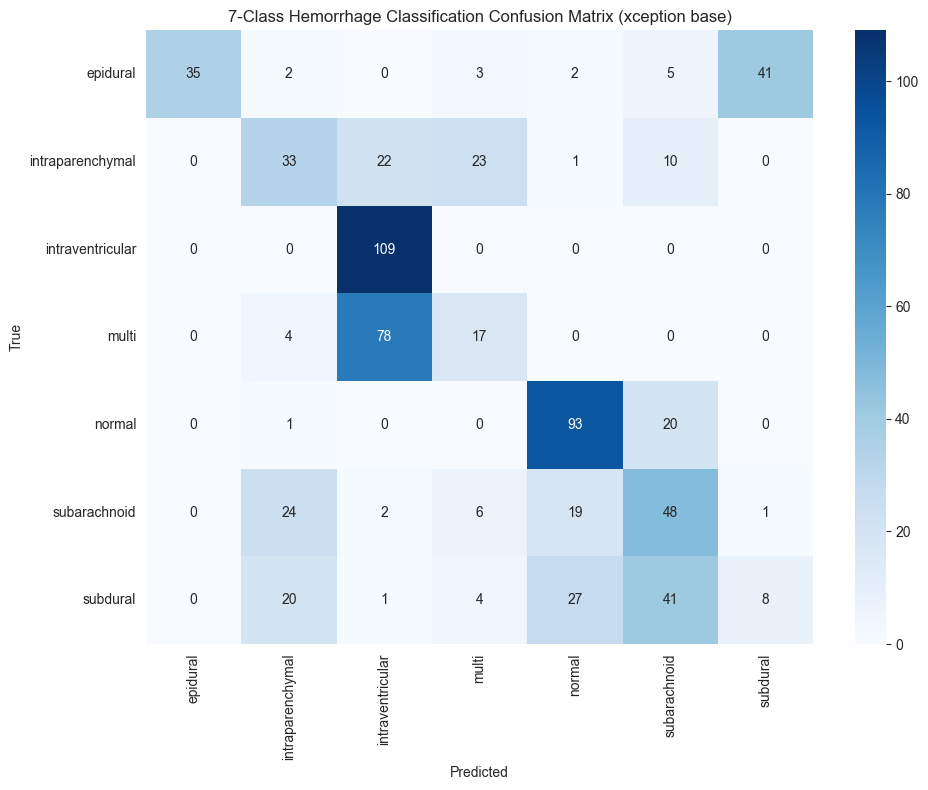


Classification Report:

                  precision    recall  f1-score   support

        epidural       1.00      0.40      0.57        88
intraparenchymal       0.39      0.37      0.38        89
intraventricular       0.51      1.00      0.68       109
           multi       0.32      0.17      0.22        99
          normal       0.65      0.82      0.73       114
    subarachnoid       0.39      0.48      0.43       100
        subdural       0.16      0.08      0.11       101

        accuracy                           0.49       700
       macro avg       0.49      0.47      0.44       700
    weighted avg       0.49      0.49      0.45       700

Overall Accuracy: 0.4900


In [6]:
# Evaluate and visualize
cm_7class = evaluate_and_visualize_confusion_matrix(
    unet_classifier,
    test_ds,
    CLASS_NAMES,
    title="7-Class Hemorrhage Classification Confusion Matrix (xception base)"
)

In [7]:
test_loss, test_accuracy = unet_classifier.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 85s 961ms/step - accuracy: 0.5009 - loss: 1.0845
Test accuracy: 0.4986


In [8]:
unet_classifier = tf.keras.models.load_model('xception_classifier_best.h5')
test_loss, test_accuracy = unet_classifier.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 902ms/step - accuracy: 0.6730 - loss: 0.8493
Test accuracy: 0.6586


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━

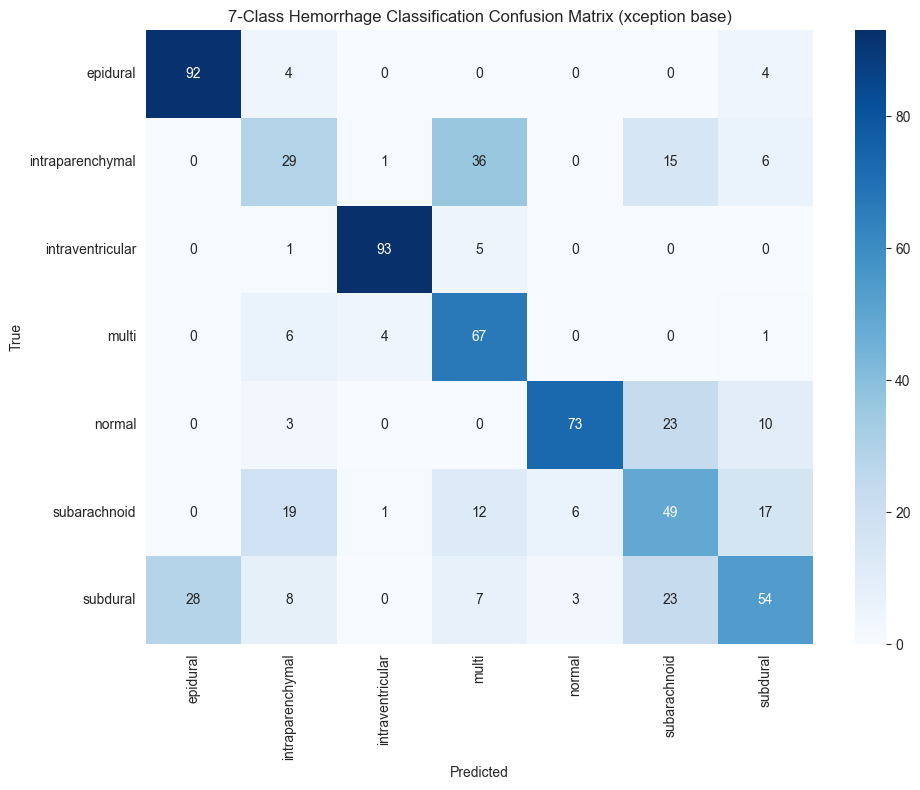


Classification Report:

                  precision    recall  f1-score   support

        epidural       0.77      0.92      0.84       100
intraparenchymal       0.41      0.33      0.37        87
intraventricular       0.94      0.94      0.94        99
           multi       0.53      0.86      0.65        78
          normal       0.89      0.67      0.76       109
    subarachnoid       0.45      0.47      0.46       104
        subdural       0.59      0.44      0.50       123

        accuracy                           0.65       700
       macro avg       0.65      0.66      0.65       700
    weighted avg       0.66      0.65      0.65       700

Overall Accuracy: 0.6529


In [9]:
# Evaluate and visualize
cm_7class2 = evaluate_and_visualize_confusion_matrix(
    unet_classifier,
    test_ds,
    CLASS_NAMES,
    title="7-Class Hemorrhage Classification Confusion Matrix (xception base)"
)